Frequentist approach to A/B testing

The aim of this notebook is to demonstrate the scenarios when we conduct the experiment in both frequentist and Bayesian frameworks Objective: LinkedIn wants to increase its conversion ratio when a customer clicks on “LinkedIn Premium” button. The underlying assumption is that the layout, information and other page factors are affecting the conversion ratio. Let’s call this current variant “A”. Thus, we want to run an A/B test comparing the performance of variant “A” with a different variant “B”. Scenario: LinkedIn decides to conduct an experiment where, the site sends them to one of two (or possibly more) different pages when a user clicks on “LinkedIn premium” button. The purpose is to determine which page version generates a superior outcome, i.e. which page generates more number of conversions. Below represents the results and their interpretation from the two approaches.Frequentist: Include cumulative conversion graphs with a vertical line representing the decision boundary on 60th day. Results. We get a p value of 0.02 and hence we can reject the null hypothesis Below is how the conversation would look like between a product manager and a product analyst/decision scientist working with him Below is a hypothetical conversation of how hard it is to explain the resultsAnalyst: Hey, good news! We got a significant result with a p value of 0.02. So we can reject the null hypothesis.Manager: That’s great! This means that we can accept the alternate hypothesis as there is 98% chance that the version b is better.Analyst: (Thinking) Well that escalated quickly.Analyst: Well the results mean that there is 2% chance to observe this sample (conversions from variant B) as extreme as this. And we can’t say anything about the probability of one variant being better than other. Even the confidence interval doesn’t indicate the how probable these values are (i.e. edge values of the confidence interval does not mean that they are less probable than middle values of the confidence interval.)Manager: Wait, what? Bayesian approach: Include cumulative conversion graph with decision boundary on 30th day and. Results: Based on the data we have observed, we are 95% sure that version “B” is better than “A”. Credible interval is __. This gives the probability of difference in conversion rates between “A” and “B” Manager: Well that makes it quite clear!These results highlight the following areas where Bayesian approach is better than frequentist approach:Sample size:Interpretability:We get information about the probabilities of the variants Now let’s discuss about   

Importing libraries

In [12]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
import scipy.stats as stats
from scipy.stats import beta

###### Generate campaign data

In [4]:
def gen_campaigns(p1,p2,nb_days,scaler,seed):
    #generate fake data
    np.random.seed(seed)
    ns = np.random.triangular(50,100,150,size=120).astype(int)
    np.random.seed(seed)
    es = np.random.randn(nb_days*2) / scaler

    n1 = ns[:nb_days]
    c1 = ((p1 + es[:nb_days]) * n1).astype(int)
    n2 = ns[nb_days:]
    c2 = ((p2 + es[nb_days:]) * n2).astype(int)
    conv_days = pd.DataFrame({'click_day':range(nb_days),'click_a':n1,'conv_a':c1,'click_b':n2,'conv_b':c2})

    conv_days =  conv_days[['click_day','click_a','click_b','conv_a','conv_b']]
    conv_days['cumu_click_a'] = conv_days.click_a.cumsum()
    conv_days['cumu_click_b'] = conv_days.click_b.cumsum()
    conv_days['cumu_conv_a'] = conv_days.conv_a.cumsum()
    conv_days['cumu_conv_b'] = conv_days.conv_b.cumsum()
    conv_days['cumu_rate_a'] = conv_days.cumu_conv_a / conv_days.cumu_click_a
    conv_days['cumu_rate_b'] = conv_days.cumu_conv_b / conv_days.cumu_click_b
    conv_days['daily_conv_rate_a'] = conv_days.conv_a/conv_days.click_a
    conv_days['daily_conv_rate_b'] = conv_days.conv_b/conv_days.click_b
    return conv_days

generating fake data

In [5]:
#generating data
conv_days = gen_campaigns(p1 = 0.08,
                          p2 = 0.092,
                          nb_days = 60,
                          scaler=100,
                          seed = 1412) #god-mode 
conv_days.head()

,click_day,click_a,click_b,conv_a,conv_b,cumu_click_a,cumu_click_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b,daily_conv_rate_a,daily_conv_rate_b
0,0,125,100,10,9,125,100,10,9,0.080000,0.090000,0.080000,0.090000
1,1,114,54,9,5,239,154,19,14,0.079498,0.090909,0.078947,0.092593
2,2,67,95,5,8,306,249,24,22,0.078431,0.088353,0.074627,0.084211
3,3,96,76,7,7,402,325,31,29,0.077114,0.089231,0.072917,0.092105
4,4,89,96,8,8,491,421,39,37,0.079430,0.087886,0.089888,0.083333


Plot of campaign data over days

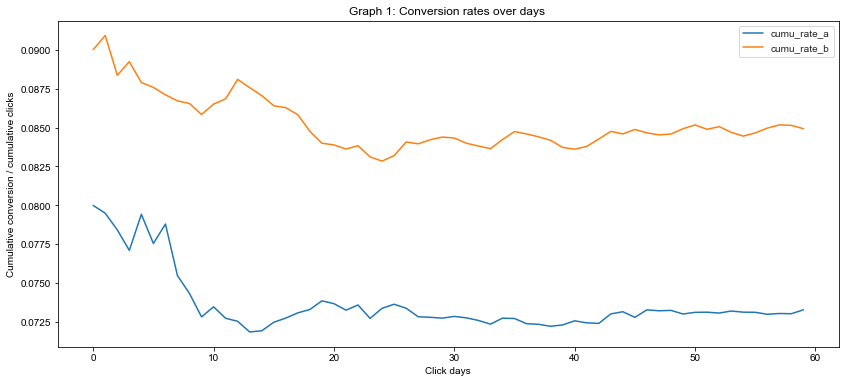

In [6]:
fig, ax = plt.subplots(figsize=(14,6))
plt.style.use('seaborn-whitegrid')
ax.plot(conv_days['click_day'], conv_days['cumu_rate_a'], label = 'cumu_rate_a')
ax.plot(conv_days['click_day'],conv_days['cumu_rate_b'], label = 'cumu_rate_b')
ax.set_title('Graph 1: Conversion rates over days ')
ax.set_ylabel('Cumulative conversion / cumulative clicks')
ax.set_xlabel('Click days')
legend = ax.legend(loc = 'best',ncol=1,frameon = True)
plt.show()

Overall campaign data 

In [7]:
campaign = pd.DataFrame({'Campaign_ID':['A','B'], 'Clicks': [conv_days.click_a.sum(),
                                                               conv_days.click_b.sum()],
                        'Conversion': [conv_days.conv_a.sum(),conv_days.conv_b.sum()],
                        'Conversion_pct': [conv_days.conv_a.sum()/conv_days.click_a.sum(),
                                           conv_days.conv_b.sum()/conv_days.click_b.sum()]})
campaign.head(5)

,Campaign_ID,Clicks,Conversion,Conversion_pct
0,A,5921,434,0.073298
1,B,5864,498,0.084925


Frequentist Power Calculations

In [74]:
# Assuming the minimum detectable difference as 5% i.e. delta = 0.05

#type I error = 5% alpha
#type II error = 20% beta
# Power = 80%

#Power and sample size calculations

# estimate sample size via power analysis
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect = 0.05
alpha = 0.05
power = 0.8
# perform power analysis
analysis = TTestIndPower()
result = TTestIndPower().solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha, alternative = 'larger')
print('Sample Size for one group: %.3f' % result)

Sample Size for one group: 4946.722


Experiment run time

In [67]:
experiment_runtime = min(conv_days.loc[(conv_days['cumu_click_b']> result ) & (conv_days['cumu_click_b'] > result)].click_day)
print('We have to run the experiment for minimum of %.f days' %experiment_runtime)

We we have to run the experiment for minimum of 50 days


Sample size Curve

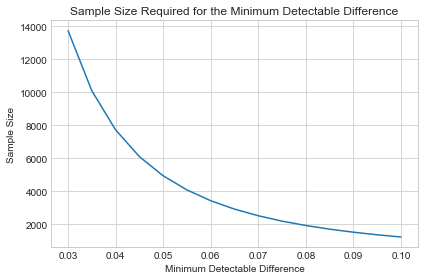

In [68]:
#Power curve

# calculate the the required sample size
# for a range of minimum detectable difference
sample_sizes = []
effect_sizes = np.arange(0.03, 0.1, 0.005)
for effect in effect_sizes:
    sample_size = TTestIndPower().solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha, alternative = 'larger')
    sample_sizes.append(sample_size)

plt.plot(effect_sizes, sample_sizes)
plt.title('Sample Size Required for the Minimum Detectable Difference')
plt.ylabel('Sample Size')
plt.xlabel('Minimum Detectable Difference')
plt.tight_layout()
plt.show()


Power curve

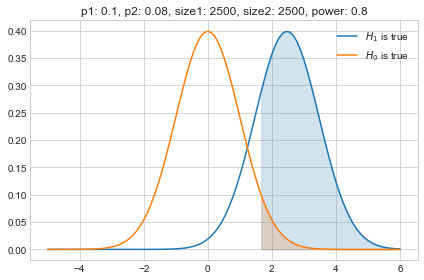

In [69]:
#H0 and H1 distribution plot with power

def plot_power(min_diff, prob_b, size_a, size_b, significance = 0.05):
    """illustrating power through a one-tailed hypothesis test"""
    
    # obtain the z-score for the minimum detectable
    # difference using proportion_ztest
    prob_a = prob_b + min_diff
    count_a = size_a * prob_a
    count_b = size_b * prob_b
    counts = np.array([count_a, count_b])
    nobs = np.array([size_a, size_b])
    zscore, _ = proportions_ztest(counts, nobs, alternative = 'larger')

    # distribution for the null hypothesis, h0
    # and alternative hypothesis, h1
    h0 = stats.norm(loc = 0, scale = 1)
    h1 = stats.norm(loc = zscore, scale = 1)

    # points that are greater than the zscore for the
    # specified significance level
    x = np.linspace(-5, 6, num = 100)
    threshold = h0.ppf(1 - significance)
    mask = x > threshold
    
    # power is the area after the threshold, i.e.
    # 1 - the cumulative distribution function of that point
    power = np.round(1 - h1.cdf(threshold), 2)

    hypotheses = [h1, h0]
    labels = ['$H_1$ is true', '$H_0$ is true']
    for hypothesis, label in zip(hypotheses, labels):
        y = hypothesis.pdf(x)
        line = plt.plot(x, y, label = label)  
        plt.fill_between(x = x[mask], y1 = 0.0, y2 = y[mask],
                         alpha = 0.2, color = line[0].get_color())
    
    title = 'p1: {}, p2: {}, size1: {}, size2: {}, power: {}'
    plt.title(title.format(prob_a, prob_b, size_a, size_b, power))
    plt.legend()
    plt.tight_layout()
    plt.show()
    
prob_b = 0.08
min_diff = 0.02
size_a = 2500
size_b = 2500

plot_power(min_diff, prob_b, size_a, size_b)
#plot_power(0.05, 0.08, 2500, 2500)

Measurement of the results after 50 days

In [8]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

click_day = 50
conversions_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_a'].values[0]
clicks_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_a'].values[0]
conversions_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_b'].values[0]
clicks_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_b'].values[0]

#zscore, pvalue = two_proprotions_test(success_a, size_a, success_b, size_b)
zscore, pvalue = two_proprotions_test(conversions_a, clicks_a, conversions_b, clicks_b)
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))


zscore = 2.230, pvalue = 0.026


Bayesian Approach

Considering Historical data

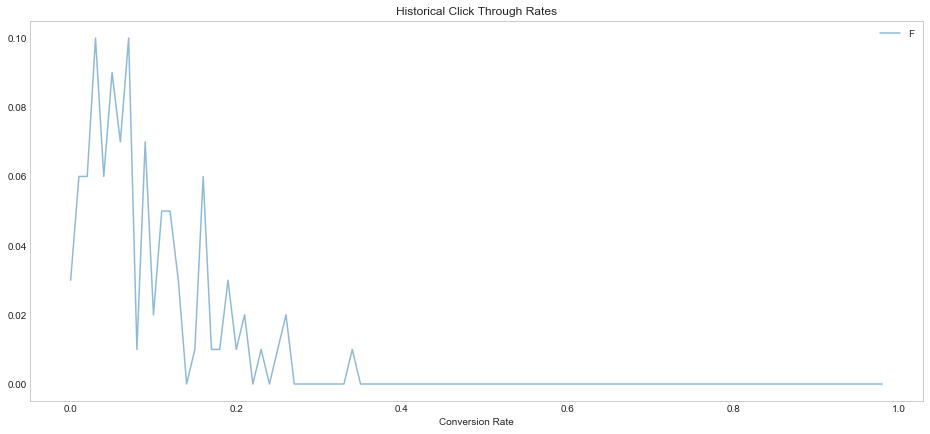

In [9]:
# Historical data on the conversion rates
plt.rcParams['figure.figsize'] = (16, 7)

true_a = 2.06 #alpha parameter of the beta distribution from which we are generating campaigns
true_b = 20 #beta parameter of the beta distribution from which we are generating campaigns

#number of marketing campaigns
N = 100

#randomly generate "true" click through rate for each campaign
p = np.random.beta(true_a,true_b, size=N)

#randomly pick the number of impressions for each campaign
impressions = np.random.randint(1, 10000, size=N)

#sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p).astype(float)
click_through_rates = clicks / impressions

#plot the histogram of previous click through rates with the evidence
#of the new campaign
f, ax = plt.subplots(1)

zero_to_one = [j/100. for j in range(100)]
counts, bins = np.histogram(click_through_rates
                            , bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
#line1, line2, line3 = ax.lines
ax.legend('Frequency of Theta Historically'
                          )
ax.set_xlabel("Conversion Rate")
ax.grid()
ax.set_title("Historical Click Through Rates")
plt.show()

Estimating beta prior

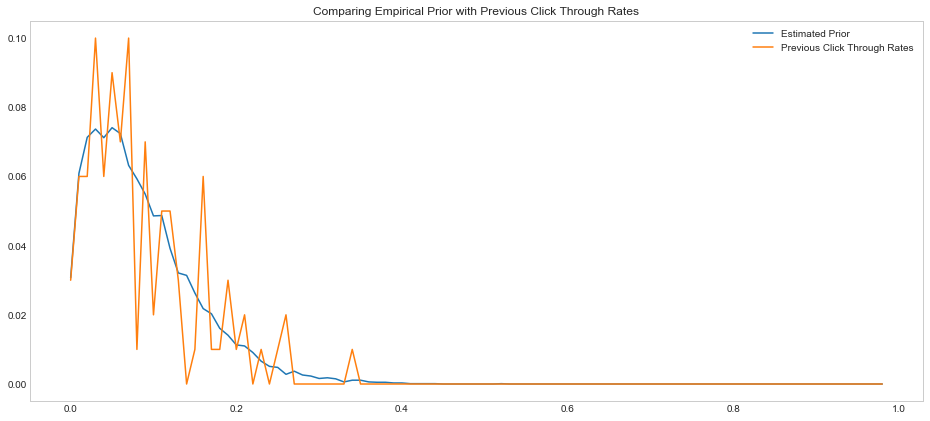

In [13]:
prior_parameters = beta.fit(click_through_rates
                            , floc = 0
                            , fscale = 1)
#extract a,b from fit
alpha_prior, beta_prior = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(alpha_prior, beta_prior)
#get histogram of samples
prior_samples = prior_distribution.rvs(10000)
#get histogram of samples
fit_counts, bins = np.histogram(prior_samples
                                , zero_to_one)
#normalize histogram
fit_counts = list(map(lambda x: float(x)/fit_counts.sum()
                         , fit_counts))

#plot
f, ax = plt.subplots(1)
ax.plot(bins[:-1], fit_counts)
hist_ctr, bins = np.histogram(click_through_rates
                              , zero_to_one)
hist_ctr = list(map(lambda x: float(x)/hist_ctr.sum()
                              , hist_ctr))
ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_click_through_rates = ax.lines
ax.legend((estimated_prior, previous_click_through_rates)
          ,('Estimated Prior'
            , 'Previous Click Through Rates'))
ax.grid()
ax.set_title("Comparing Empirical Prior with Previous Click Through Rates")
plt.show()

Finding a posterior distribution for a beta binomial conjugate prior

In [17]:
#posterior distribution
def posterior(alpha_prior, beta_prior, variant, click_day):    
    
    alpha_prior = alpha_prior
    beta_prior = beta_prior
    
    if variant == 'A':  
        conversions_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_a'].values[0]
        clicks_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_a'].values[0]
        alpha_posterior = alpha_prior+conversions_a
        beta_posterior = beta_prior + clicks_a - conversions_a
        posterior_beta_distri = stats.beta(alpha_posterior, beta_posterior)
        print("alpha and beta for posterior dissribution of variant 'A' will be ", 
              alpha_posterior, "and" , beta_posterior)

    elif variant == 'B':
        conversions_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_b'].values[0]
        clicks_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_b'].values[0]
        alpha_posterior = alpha_prior+conversions_b
        beta_posterior = beta_prior + clicks_b - conversions_b
        posterior_beta_distri = stats.beta(alpha_posterior, beta_posterior)
        print("alpha and beta for posterior dissribution of variant 'B' will be ", 
              alpha_posterior, "and" , beta_posterior)
        
    else:
        print("pass third argumet as as variant you want i.e. 'A' or 'B' ")
    
    return posterior_beta_distri

Function to find out difference between pdfs of two beta distribution based on John Cook's solution

This could also be done by Monte Carlo Simulations

In [16]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)
@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))
@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d
def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))
def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

Calculating Posterior from beta binomial prior based on a daily basis and estimating probabilities

alpha and beta for posterior dissribution of variant 'A' will be  11.6880734621692 and 131.52749278430696
alpha and beta for posterior dissribution of variant 'B' will be  10.6880734621692 and 107.52749278430696
alpha and beta for posterior dissribution of variant 'A' will be  20.6880734621692 and 236.52749278430696
alpha and beta for posterior dissribution of variant 'B' will be  15.6880734621692 and 156.52749278430696
alpha and beta for posterior dissribution of variant 'A' will be  25.6880734621692 and 298.52749278430696
alpha and beta for posterior dissribution of variant 'B' will be  23.6880734621692 and 243.52749278430696
alpha and beta for posterior dissribution of variant 'A' will be  32.6880734621692 and 387.52749278430696
alpha and beta for posterior dissribution of variant 'B' will be  30.6880734621692 and 312.52749278430696
alpha and beta for posterior dissribution of variant 'A' will be  40.6880734621692 and 468.52749278430696
alpha and beta for posterior dissribution of v

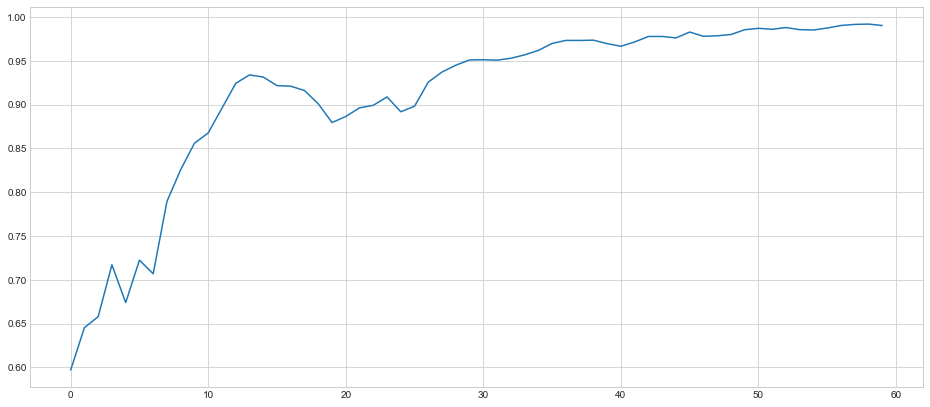

In [18]:
daily_cumu_prob = []
for day in range(60):
    a = posterior(alpha_prior,beta_prior,'A',day)
    b = posterior(alpha_prior,beta_prior,'B',day)
    prob=calc_prob_between(b,a)
    daily_cumu_prob.append(prob) 

plt.plot(range(60), daily_cumu_prob)

In [28]:
#After 30th Day
day1 = 30
a1 = posterior(alpha_prior,beta_prior,'A',day1)
b1 = posterior(alpha_prior,beta_prior,'B',day1)

lift1=(b1.mean()-a1.mean())/a1.mean()
#calculating the probability for Test to be better than Control
prob1=calc_prob_between(b1,a1)

day2 = 59
a2 = posterior(alpha_prior,beta_prior,'A',day2)
b2 = posterior(alpha_prior,beta_prior,'B',day2)

lift2=(b2.mean()-a2.mean())/a2.mean()
#calculating the probability for Test to be better than Control
prob2=calc_prob_between(b2,a2)

print("After day 30: Lift from variant B is {0:.2f}%, and probability of B being better than A based on data is {1:.2f}%".format(lift1*100, prob1*100))
print("After day 60: Lift from variant B is {0:.2f}%, and probability of B being better than A based on data is {1:.2f}%".format(lift2*100, prob2*100))

alpha and beta for posterior dissribution of variant 'A' will be  231.6880734621692 and 2942.527492784307
alpha and beta for posterior dissribution of variant 'B' will be  249.6880734621692 and 2709.527492784307
alpha and beta for posterior dissribution of variant 'A' will be  435.6880734621692 and 5503.527492784307
alpha and beta for posterior dissribution of variant 'B' will be  499.6880734621692 and 5382.527492784307
After day 30: Lift from variant B is 15.60%, and probability of B being better than A based on data is 95.12%
After day 60: Lift from variant B is 15.80%, and probability of B being better than A based on data is 99.03%


Monte Carlo simulation for the same

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:49<00:00, 835.66draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 1 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:47<00:00, 855.74draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 2 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:55<00:00, 739.72draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 3 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:08<00:00, 596.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 4 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:52<00:00, 784.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 5 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:56<00:00, 725.12draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 6 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:54<00:00, 753.47draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 7 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:59<00:00, 686.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 8 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:01<00:00, 661.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 9 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:58<00:00, 701.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 10 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:00<00:00, 679.60draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 11 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:53<00:00, 763.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 12 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:55<00:00, 744.45draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 13 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:55<00:00, 745.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 14 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:49<00:00, 835.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 15 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:55<00:00, 738.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 16 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:55<00:00, 733.92draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 17 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:58<00:00, 695.64draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 18 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:10<00:00, 583.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 19 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:50<00:00, 809.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 20 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:58<00:00, 703.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 21 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:54<00:00, 757.31draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 22 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:05<00:00, 626.74draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 23 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:05<00:00, 629.01draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 24 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:05<00:00, 623.26draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 25 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:03<00:00, 644.40draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 26 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:54<00:00, 755.72draws/s]
The number of effective samples is smaller than 10% for some parameters.


simulation for day 27 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:17<00:00, 527.04draws/s]
The number of effective samples is smaller than 10% for some parameters.


simulation for day 28 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:48<00:00, 850.60draws/s]
The number of effective samples is smaller than 25% for some parameters.


simulation for day 29 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:46<00:00, 878.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


simulation for day 30 complete


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [01:14<00:00, 552.58draws/s]
The number of effective samples is smaller than 10% for some parameters.


simulation for day 31 complete


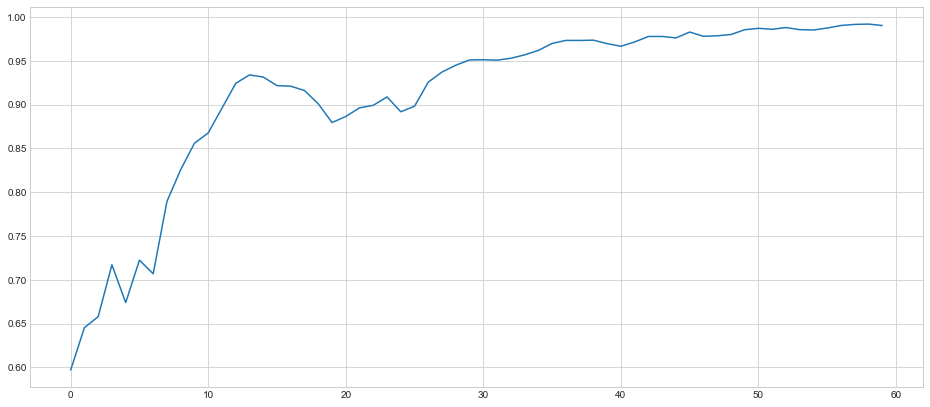

In [34]:
daily_cumu_prob_mcmc = []
x = 0 #counter

for click_day in range(31):
    conversions_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_a'].values[0]
    clicks_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_a'].values[0]
    conversions_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_b'].values[0]
    clicks_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_b'].values[0]

    x += 1
    with pm.Model() as model:
        
        p_A = pm.Beta("p_A", alpha_prior, beta_prior)
        p_B = pm.Beta("p_B",alpha_prior, beta_prior)
        
        # Define the deterministic delta function. This is our unknown of interest.
        delta = pm.Deterministic("delta", p_A - p_B)
    
        
        # Set of observations, in this case we have two observation datasets.
        obs_A = pm.Binomial("obs_A", p=p_A, n = clicks_a, observed=conversions_a)
        obs_B = pm.Binomial("obs_B", p=p_B, n = clicks_b, observed=conversions_b)
    
        # To be explained in chapter 3.
        step = pm.Metropolis()
        trace = pm.sample(20000, step=step, progressbar = True)
        burned_trace=trace[1000:]
        
       
    p_A_samples = burned_trace["p_A"]
    p_B_samples = burned_trace["p_B"]
    delta_samples = burned_trace["delta"]
    
    daily_cumu_prob_mcmc.append(np.mean(delta_samples > 0))
    print("simulation for day {0} complete".format(x))
    
plt.plot(range(60), daily_cumu_prob)   

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB78B4EA20>,
      dtype=object)

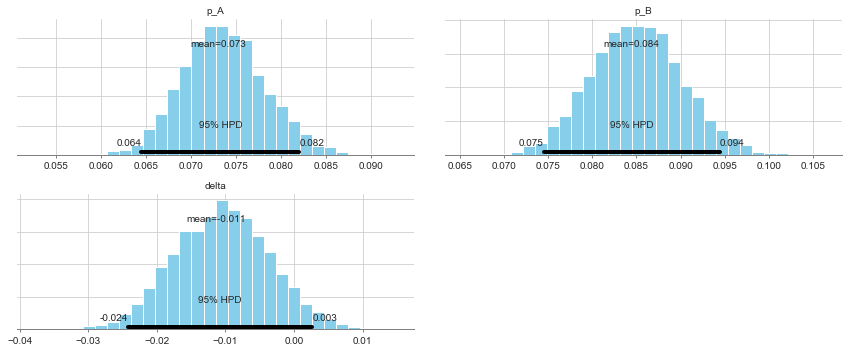

In [38]:
#plt.plot(range(60), daily_cumu_prob)   
pm.plot_posterior(burned_trace, color='#87ceeb')

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [00:48<00:00, 841.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB7BD7D6A0>,
      dtype=object)

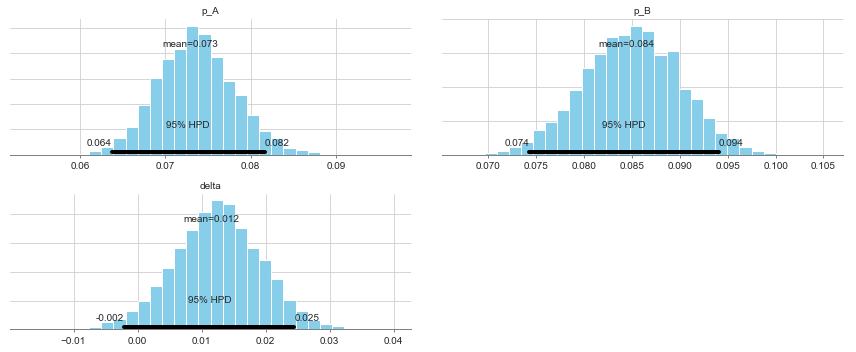

In [40]:
with pm.Model() as model:
        
        p_A = pm.Beta("p_A", alpha_prior, beta_prior)
        p_B = pm.Beta("p_B",alpha_prior, beta_prior)
        
        # Define the deterministic delta function. This is our unknown of interest.
        delta = pm.Deterministic("delta", p_B - p_A)
    
        
        # Set of observations, in this case we have two observation datasets.
        obs_A = pm.Binomial("obs_A", p=p_A, n = clicks_a, observed=conversions_a)
        obs_B = pm.Binomial("obs_B", p=p_B, n = clicks_b, observed=conversions_b)
    
        # To be explained in chapter 3.
        step = pm.Metropolis()
        trace = pm.sample(20000, step=step, progressbar = True)
        burned_trace=trace[1000:]
        
       
        p_A_samples = burned_trace["p_A"]
        p_B_samples = burned_trace["p_B"]
        delta_samples = burned_trace["delta"]

pm.plot_posterior(burned_trace, color='#87ceeb')

In [41]:
pm.summary(trace)

C:\Users\chaitanya.srivastava\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_A,0.072903,0.004561,0.000067,0.063690,0.081588,4684.576537,0.999979
p_B,0.084412,0.005057,0.000087,0.074387,0.094132,3922.992215,0.999994
delta,0.011509,0.006762,0.000116,-0.002086,0.024589,4179.297986,0.999979
